In [28]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

import pandas as pd
from IPython.core.display import display
import seaborn as sns
import numpy as np
import warnings 
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from string import ascii_letters
import sys
import gc
import pickle
import time

In [4]:
spark = (
    SparkSession.builder.appName("ModelTraining")
    .config("spark.executor.memory", "2g")
    .getOrCreate()
)

In [41]:
df_train = (
    spark.read.csv("/home/jovyan/work/sales_train.csv", header=True, inferSchema=True)
    .withColumn("date", to_date(col("date"),"dd.MM.yyyy"))
)
df_test = spark.read.csv("/home/jovyan/work/test.csv", header=True, inferSchema=True)
df_submission = spark.read.csv("/home/jovyan/work/sample_submission.csv", header=True, inferSchema=True)
df_shop = spark.read.csv("/home/jovyan/work/shops.csv", header=True, inferSchema=True)
df_item_cat = spark.read.csv("/home/jovyan/work/item_categories.csv", header=True, inferSchema=True)
df_item  = spark.read.csv("/home/jovyan/work/items.csv", header=True, inferSchema=True)

In [34]:
df_train.show()

+----------+--------------+-------+-------+----------+------------+
|      date|date_block_num|shop_id|item_id|item_price|item_cnt_day|
+----------+--------------+-------+-------+----------+------------+
|02.01.2013|             0|     59|  22154|     999.0|         1.0|
|03.01.2013|             0|     25|   2552|     899.0|         1.0|
|05.01.2013|             0|     25|   2552|     899.0|        -1.0|
|06.01.2013|             0|     25|   2554|   1709.05|         1.0|
|15.01.2013|             0|     25|   2555|    1099.0|         1.0|
+----------+--------------+-------+-------+----------+------------+
only showing top 5 rows



In [22]:
print("Shape of the data Set is :  ",(df_train.count(), len(df_train.columns)))

Shape of the data Set is :   (2935849, 6)


In [42]:
df_train.printSchema()

root
 |-- date: date (nullable = true)
 |-- date_block_num: integer (nullable = true)
 |-- shop_id: integer (nullable = true)
 |-- item_id: integer (nullable = true)
 |-- item_price: double (nullable = true)
 |-- item_cnt_day: double (nullable = true)



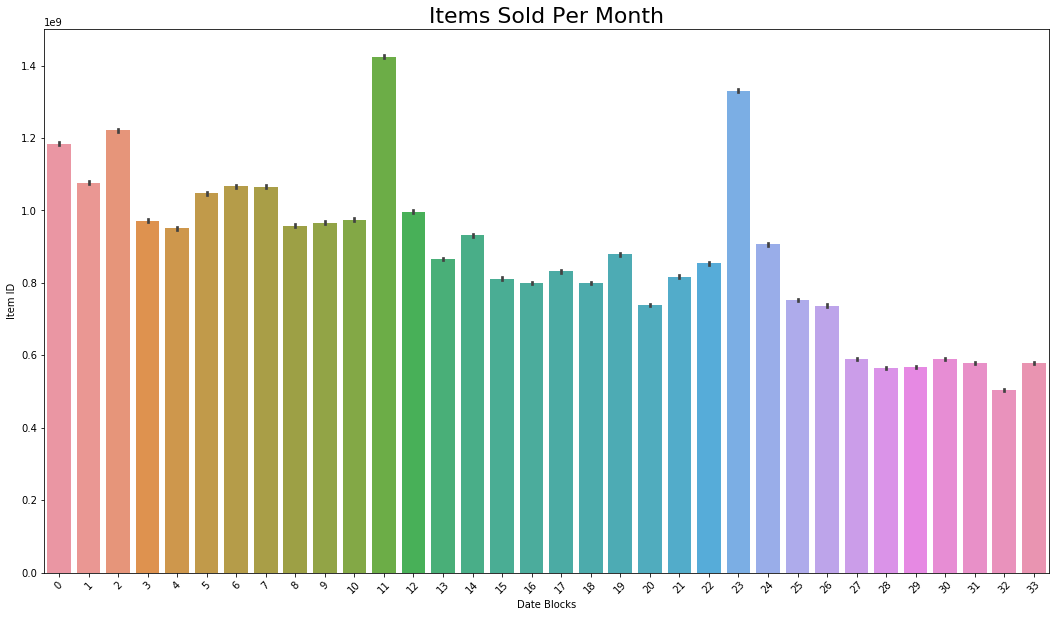

CPU times: user 47.7 s, sys: 713 ms, total: 48.4 s
Wall time: 50.8 s


In [45]:
%%time
plt.figure(figsize = (18,10))
plt.title('Items Sold Per Month', fontsize=22)
ax = sns.barplot(x='date_block_num', y="item_id", data=df_train.toPandas(), estimator=np.sum)
ax = ax.set(xlabel='Date Blocks', ylabel='Item ID')
plt.xticks(rotation=45)
plt.show() 

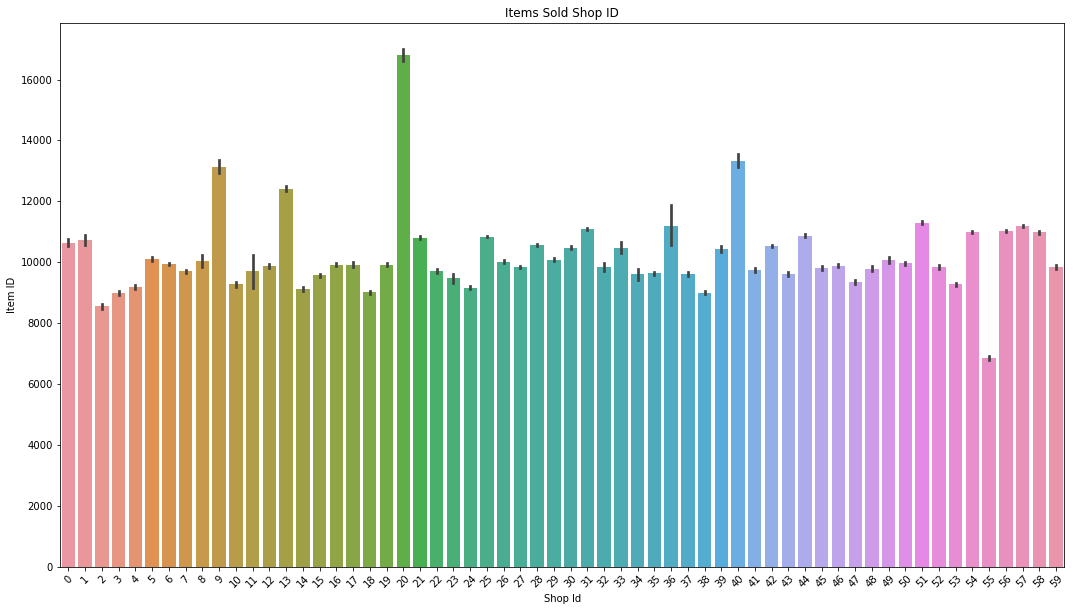

CPU times: user 48 s, sys: 700 ms, total: 48.7 s
Wall time: 51.3 s


In [46]:
%%time
plt.figure(figsize = (18,10))
plt.title('Items Sold Shop ID')
ax = sns.barplot(x='shop_id', y="item_id", data=df_train.toPandas(), estimator=np.mean)
ax = ax.set(xlabel='Shop Id', ylabel='Item ID')
plt.xticks(rotation=45)
plt.show() 

In [50]:
df_shop.limit(2).toPandas()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"""!Якутск ТЦ """"Центральный"""" фран""",1


,shop_name
0,"!Якутск Орджоникидзе, 56 фран"
1,"""!Якутск ТЦ """"Центральный"""" фран"""
2,"""Адыгея ТЦ """"Мега"""""""
3,"""Балашиха ТРК """"Октябрь-Киномир"""""""
4,"""Волжский ТЦ """"Волга Молл"""""""
5,"""Вологда ТРЦ """"Мармелад"""""""
6,"Воронеж (Плехановская, 13)"
7,"""Воронеж ТРЦ """"Максимир"""""""
8,"""Воронеж ТРЦ Сити-Парк """"Град"""""""
9,Выездная Торговля


In [84]:
split_col = split(df_shop['shop_name'], ' ')
df_shop = df_shop.withColumn('City', split_col.getItem(0))
df_shop = df_shop.withColumn('City', regexp_replace('City', '"', ''))
df_shop = df_shop.withColumn('City', regexp_replace('City', '!', ''))
df_shop.toPandas()

,shop_name,shop_id,City
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск
1,"""!Якутск ТЦ """"Центральный"""" фран""",1,Якутск
2,"""Адыгея ТЦ """"Мега""""""",2,Адыгея
3,"""Балашиха ТРК """"Октябрь-Киномир""""""",3,Балашиха
4,"""Волжский ТЦ """"Волга Молл""""""",4,Волжский
5,"""Вологда ТРЦ """"Мармелад""""""",5,Вологда
6,"Воронеж (Плехановская, 13)",6,Воронеж
7,"""Воронеж ТРЦ """"Максимир""""""",7,Воронеж
8,"""Воронеж ТРЦ Сити-Парк """"Град""""""",8,Воронеж
9,Выездная Торговля,9,Выездная


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text xticklabel objects>)

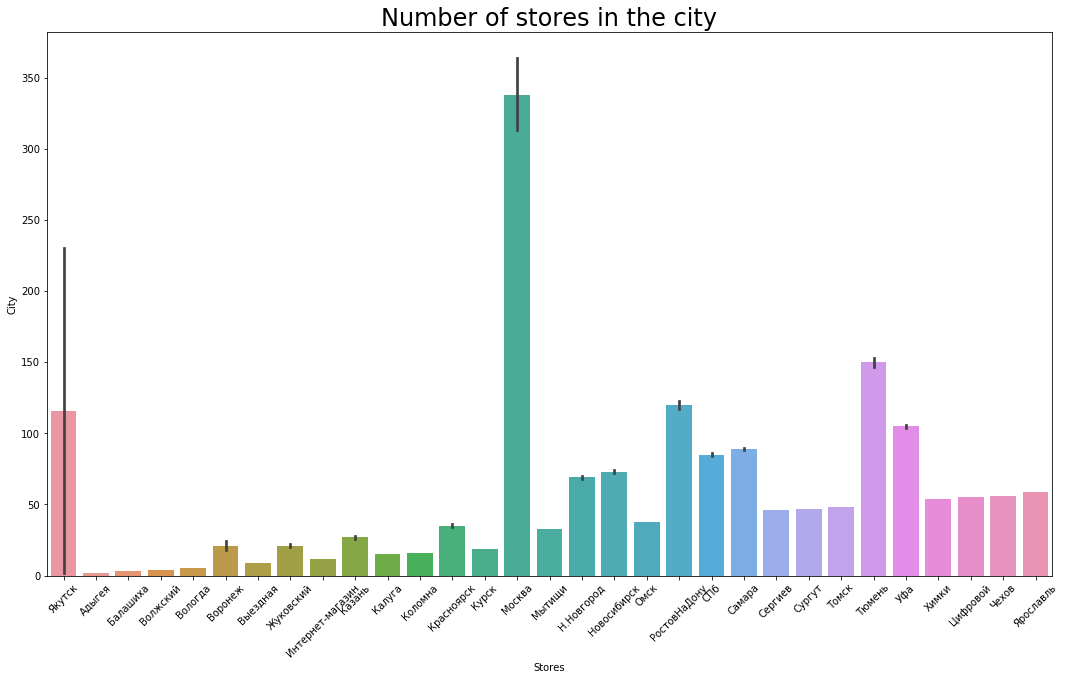

In [86]:
plt.figure(figsize = (18,10))
plt.title( "Number of stores in the city", fontsize=24)
ax = sns.barplot(x="City", y="shop_id", data=df_shop.toPandas(), estimator=np.sum)
ax = ax.set(xlabel='Stores', ylabel='City')
plt.xticks(rotation=45)

In [87]:
df_item.limit(2).toPandas()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76


In [88]:
df_item.select("item_name").distinct().count()

22154

In [89]:
df_item_cat.limit(2).toPandas()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1


In [90]:
split_col = split(df_item_cat['item_category_name'], '-')
df_item_cat = df_item_cat.withColumn("type", split_col.getItem(0))
df_item_cat = df_item_cat.withColumn("subtype", split_col.getItem(1))
df_item_cat.drop("item_category_name").show()

+----------------+----------------+-------------------+
|item_category_id|            type|            subtype|
+----------------+----------------+-------------------+
|               0|             PC | Гарнитуры/Наушники|
|               1|     Аксессуары |                PS2|
|               2|     Аксессуары |                PS3|
|               3|     Аксессуары |                PS4|
|               4|     Аксессуары |                PSP|
|               5|     Аксессуары |             PSVita|
|               6|     Аксессуары |           XBOX 360|
|               7|     Аксессуары |           XBOX ONE|
|               8|  Билеты (Цифра)|               null|
|               9| Доставка товара|               null|
|              10|Игровые консоли |                PS2|
|              11|Игровые консоли |                PS3|
|              12|Игровые консоли |                PS4|
|              13|Игровые консоли |                PSP|
|              14|Игровые консоли |             

In [101]:
print("    Unique Types: ",df_item_cat.select("type").distinct().na.drop().count())
print("Unique Sub Types: ",df_item_cat.select("subtype").distinct().na.drop().count())

    Unique Types:  21
Unique Sub Types:  58


(array([  0., 100., 200., 300., 400., 500., 600., 700., 800., 900.]),
 <a list of 10 Text xticklabel objects>)

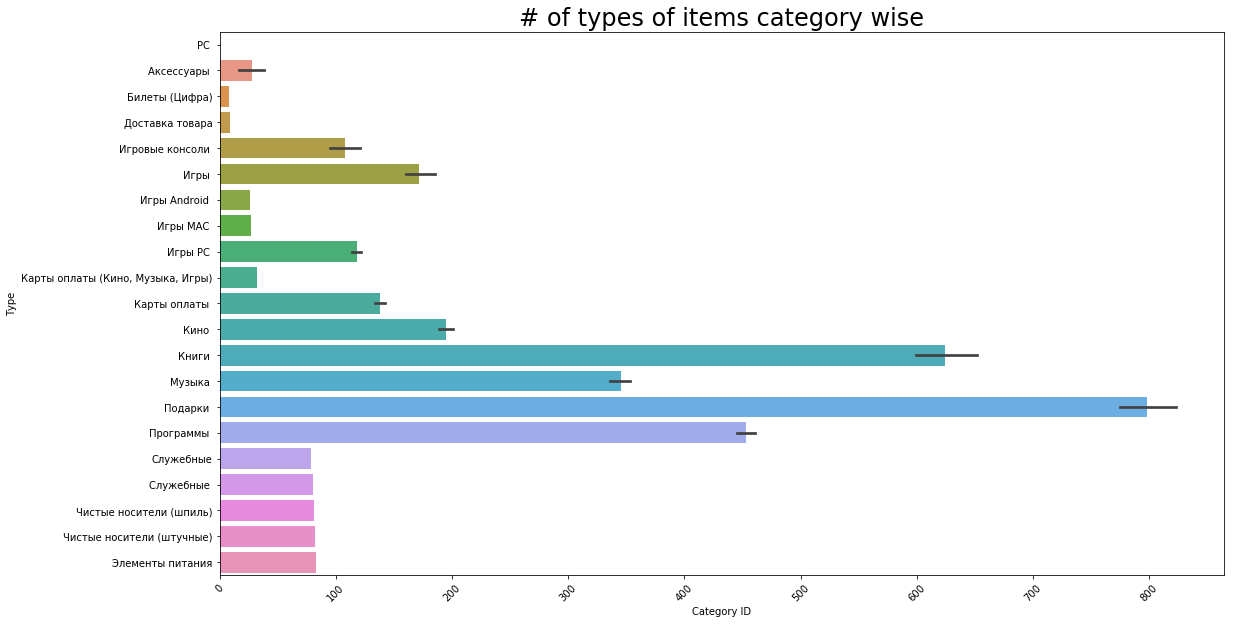

In [102]:
plt.figure(figsize = (18,10))
plt.title('# of types of items category wise', fontsize=24)
ax = sns.barplot(x='item_category_id', y='type', data=df_item_cat.toPandas(), estimator=np.sum)
ax = ax.set(xlabel='Category ID', ylabel='Type')
plt.xticks(rotation=45)

In [103]:
master_data = df_train.join(df_item, "item_id", "left")

In [105]:
master_data = master_data.join(df_item_cat, "item_category_id", "left")

In [106]:
master_data = master_data.join(df_shop, "shop_id", "left")

In [134]:
print("Shape of the data Set is :  ",(master_data.count(), len(master_data.columns)))

Shape of the data Set is :   (2935849, 13)


In [136]:
master_data.limit(20).toPandas()

,shop_id,item_category_id,item_id,date,date_block_num,item_price,item_cnt_day,item_name,item_category_name,type,subtype,shop_name,City
0,59,37,22154,2013-01-02,0,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,Кино,Blu,"""Ярославль ТЦ """"Альтаир""""""",Ярославль
1,25,58,2552,2013-01-03,0,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,Музыка - Винил,Музыка,Винил,"""Москва ТРК """"Атриум""""""",Москва
2,25,58,2552,2013-01-05,0,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,Музыка - Винил,Музыка,Винил,"""Москва ТРК """"Атриум""""""",Москва
3,25,58,2554,2013-01-06,0,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,Музыка - Винил,Музыка,Винил,"""Москва ТРК """"Атриум""""""",Москва
4,25,56,2555,2013-01-15,0,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),Музыка - CD фирменного производства,Музыка,CD фирменного производства,"""Москва ТРК """"Атриум""""""",Москва
5,25,59,2564,2013-01-10,0,349.00,1.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,Музыка - Музыкальное видео,Музыка,Музыкальное видео,"""Москва ТРК """"Атриум""""""",Москва
6,25,56,2565,2013-01-02,0,549.00,1.0,DEEP PURPLE Stormbringer (фирм.),Музыка - CD фирменного производства,Музыка,CD фирменного производства,"""Москва ТРК """"Атриум""""""",Москва
7,25,55,2572,2013-01-04,0,239.00,1.0,DEFTONES Koi No Yokan,Музыка - CD локального производства,Музыка,CD локального производства,"""Москва ТРК """"Атриум""""""",Москва
8,25,55,2572,2013-01-11,0,299.00,1.0,DEFTONES Koi No Yokan,Музыка - CD локального производства,Музыка,CD локального производства,"""Москва ТРК """"Атриум""""""",Москва
9,25,55,2573,2013-01-03,0,299.00,3.0,DEL REY LANA Born To Die,Музыка - CD локального производства,Музыка,CD локального производства,"""Москва ТРК """"Атриум""""""",Москва


In [150]:
month = master_data.groupby("date_block_num", "shop_id", "item_id").agg(mean("item_price").alias("item_price"), sum("item_cnt_day").alias("item_cnt_day"))

In [151]:
print("Shape of the data Set is :  ",(month.count(), len(master_data.columns)))

Shape of the data Set is :   (1609124, 13)


In [157]:
month = month.withColumn('tota_sales', month['item_price']*month['item_cnt_day'])

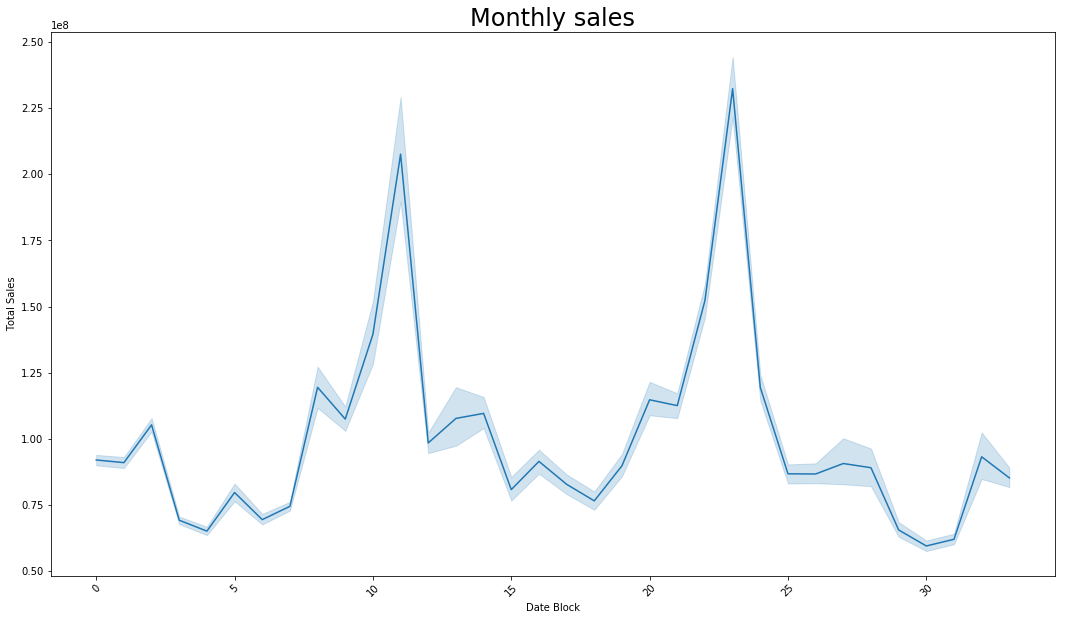

In [158]:
plt.figure(figsize = (18,10))
plt.title('Monthly sales', fontsize=24)
ax = sns.lineplot(x='date_block_num', y='tota_sales', data=month.toPandas(), estimator=np.sum)
ax = ax.set(xlabel='Date Block', ylabel='Total Sales')
plt.xticks(rotation=45)

plt.show() 

In [166]:
month = month.withColumn("month", (col('date_block_num')+1)%12)

+--------------+-------+-------+----------+------------+----------+-----+
|date_block_num|shop_id|item_id|item_price|item_cnt_day|tota_sales|month|
+--------------+-------+-------+----------+------------+----------+-----+
|             0|     25|   1051|     649.0|         1.0|     649.0|    1|
|             0|     25|   5976|     349.0|         1.0|     349.0|    1|
|             0|     25|   5525|     299.0|         1.0|     299.0|    1|
|             0|     25|   4518|     599.0|         1.0|     599.0|    1|
|             0|     24|   7856|     799.0|         5.0|    3995.0|    1|
|             0|     24|    816|      99.0|         1.0|      99.0|    1|
|             0|     25|    154|     299.0|         6.0|    1794.0|    1|
|             0|     24|  11228|     149.0|         1.0|     149.0|    1|
|             0|     24|   8066|     349.0|         1.0|     349.0|    1|
|             0|     24|  13157|     249.0|         1.0|     249.0|    1|
|             0|     25|  14488|     3